<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Image_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b> How to use PISTA for image simulation</b></h1>

# **Initialize**

Do not edit this section

In [1]:
!pip install insist-pista --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 62.9 MB/s eta 0:00:00


In [2]:
import pista as pis

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import os
from pathlib import Path

import astropy.units as u
from astropy.table import Table,vstack
from astropy.visualization import make_lupton_rgb

import seaborn as sb

In [3]:
data_path = Path(pis.__file__).parent.joinpath() # Path to package data
data_path

PosixPath('/usr/local/lib/python3.8/dist-packages/pista')

# **Python Image Simulation and Testing Application (PISTA)**

PISTA package allows user to simulate resolved stellar population using source catalog and detector characteristics. This notebook contains few examples on how to use PISTA

## **Step 1**
Upload a dataframe with columns 'ra', 'dec', 'mag'.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving phatm31.fits to phatm31.fits


In [ ]:
ls # Shows the files in the current working directory

In [4]:
# Example using FITS table
tab = Table.read(f'{data_path}/data/sample.fits')  # FITS Table
df  = tab.to_pandas()             # PISTA requires pandas DataFrame
df

,ra,dec,mag,s_F275W
0,11.058884,41.343124,19.441000,110.800003
1,11.060650,41.343782,24.539000,5.200000
2,11.061190,41.343785,21.142000,46.599998
3,11.061413,41.345837,24.612000,6.000000
4,11.061744,41.343196,22.931000,17.700001
...,...,...,...,...
534,11.071035,41.358390,24.594000,5.700000
535,11.071245,41.358205,24.337999,6.900000
536,11.071255,41.358967,20.018000,84.300003
537,11.071642,41.359526,24.660999,5.400000


## **Step 2**

Create a dictionary object with telescope parameters.


Dictionary structure
       
```
tel_params : dict, 
 |                   {'aperture'       : float,  cm
 |                    'pixel_scale'    : float,  arcsecs/pixels
 |                    'psf_file'       : fits,npy 
 |                    'response_funcs' : list, [filename.dat, n, max] 
 |
 |                                             where 
 |                                             n is number of times
 |                                             a given profile is repeated.
 |                                             For example if there are 5
 |                                             mirrors with sample coating
 |                                             profile, n = 5. 
 |                                             
 |                                             max is the upper limit of a
 |                                             response function. For example,
 |                                             if filter profiles are in 
 |                                             percentage, max = 100.
 |                                           
 |                    'coeffs'         : float, filter coefficients if not
 |                                            response_funcs
 |                    } 
```

aperture : aperture of the primary mirror in cms <br>

pixel_scale : pixel scale of the detector in arcseconds/pixels<br>

sim_file    : path to the file containing point spread function data in the form of a 2D array. User can use both npy or FITS data. <br>

response_funcs : Dictionary containing paths to filter, dichroic, coating efficiency, quantum efficieny etc. profiles.<br>

Format for dictionary is [\<path>, \<multiplicity factor>, \<maximum value>]<br>


```
response_funcs = [
                   '..\path\coating.dat,1,100',
                   '..\path\dichroic.dat,2,1'
                 ]
                 
```

coeffs : response coefficient. If user doesn't wanna use filter and response function profiles. They can directly enter the total multiplicate factor that needs to go into the effective area. Such that coeff = c1*c2*c3*.. 

Where c1,c2,c3 are response function coefficients

In the example below we will use INSIST parameters which is included in the PISTA package data 

In [5]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/data/PSF/INSIST/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_path}/data/INSIST/UV/Filter.dat,1,100',    
                                  f'{data_path}/data/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                  f'{data_path}/data/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  f'{data_path}/data/INSIST/UV/QE.dat,1,100'
                                ],                                
            } 

## **Step 3**

Initialize PISTA Analyzer object

n_x : Number of pixels along RA direction. <br>
n_y : Number of pixels along Dec direction <br>
exp_time : Exposure time in seconds

In [6]:
sim = pis.Imager(df = df,tel_params = tel_params, n_x = 500, n_y = 500, 
                   exp_time = 2400)

In [ ]:
sim.show_field () # Displays the RA-Dec scatter of sources withing the Field of View

## **Step 4**

Create dictionary object with Detector parameters



```
det_params: dict, optional  
        Dictionary contianing detector parameters. The default is None.
                   {     'shot_noise' :  str,
                         'M_sky'      :  float,
                         'qe_sigma'   :  float,       Pixel to pixel fluctuation
                         'bias'       :  float,       electrons
                         'G1'         :  float,
                         'bit_res'    :  int,         
                         'RN'         :  float,       elec/pix
                         'PRNU_frac'  :  float,       PRNU sigma
                         'T'          :  float,       K
                         'DFM'        :  float,       pA
                         'pixel_area' :  float,       
                         'DN'         :  float,     
                         'NF'         :  float,       electrons 
                         'FWC'        :  float,       electrons 
                         'C_ray_r'    :  float        hits/second
                     }
```


shot_noise : Distribuition to be used for shot_noise, 'Gaussian' or 'Possonian' <br>

M_sky : sky magnitude in $ABmag/arcsecond^2$. If filter profiles are not used.<br>

qe_sigma : standard deviation of quantum efficiency across pixel on the detector. <br>

bias : detector offset in electrons<br>

G1   : Detector gain<br>

bit_res : bit resolution of the detector<br>

RN      : Read noise of the detector in electrons<br>

PRNU_frac: Photon Responce non uniformity fraction<br>

T        : Temperature of the detector in Kelvin <br>

DFM      : Dark Current figure of meric in unit $pA/cm^2$ <br>

pixel_area : area of pixel in cm^2 <br>

DN   : Dark Current fixed pattern fraction <br>

NF   : Noise floor in electrons<br>

C_ray_r' cosmic ray hits rate $hits/second/arcsecond^2$

In [8]:
det_params = {    'shot_noise' :  'Gaussian',
                  'G1'         :  1,
                  'PRNU_frac'  :  0.25/100,
                  'RN'         :  5,
                  'T'          :  218,        
                  'DN'         :  0.1/100     
                     }

## **Step 5**

Run simulation by calling the sim object with required arguments

In [21]:
sim(det_params = det_params, photometry = 'Aper', detect_source = False)

/usr/local/lib/python3.8/dist-packages/pista/analysis.py:98: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out']  = -2.5*np.log10(phot_table['flux']/zero_p_flux)


In [ ]:
sim.show_image(cmap = 'gray') # Displays the final simulated digital image

In [ ]:
sim.show_image('DC') # Shows dark current frame 

In [ ]:
sim.show_hist() # Shows histogram of final image

In [ ]:
sim.show_hist('DC') #Shows histogram of dark current frame

In [ ]:
sim.phot_table # Displays table with aperture photometry of the image

**Comparing input magnitude vs output magnitude**

In [ ]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out']-sim.phot_table['mag_in']

plt.figure(figsize = (10,5))
plt.scatter(x, y)
plt.xlabel('Input (Mag)')
plt.ylabel('Output - Input (Mag)')

**Downloading output image as FITS**

In [ ]:
sim.writeto('sample_sim.fits')

In [ ]:
from google.colab import files

files.download('sample.fits')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Explorative Analysis using the Simulator**

In this section we use PISTA to generate few standard plots and perform some analysis

### **Photon Response Curves**

/usr/local/lib/python3.8/dist-packages/pista/analysis.py:98: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out']  = -2.5*np.log10(phot_table['flux']/zero_p_flux)
<ipython-input-26-a6e018ecc285>:43: RuntimeWarning: invalid value encountered in sqrt
  y = x/np.sqrt(sim.source_photoelec).ravel()
/usr/local/lib/python3.8/dist-packages/pista/analysis.py:98: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out']  = -2.5*np.log10(phot_table['flux']/zero_p_flux)
<ipython-input-26-a6e018ecc285>:67: RuntimeWarning: invalid value encountered in sqrt
  y = x/np.sqrt(sim.photoelec_array + sim.DC_array**2 ).ravel()
/usr/local/lib/python3.8/dist-packages/pista/analysis.py:98: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out']  = -2.5*np.log10(phot_table['flux']/zero_p_flux)
<ipython-input-26-a6e018ecc285>:83: RuntimeWarning: invalid value encountered in sqrt
  y = x/np.sqrt(sim.photoelec_array + sim.DC_array**2+ (sim.photoelec_array*s

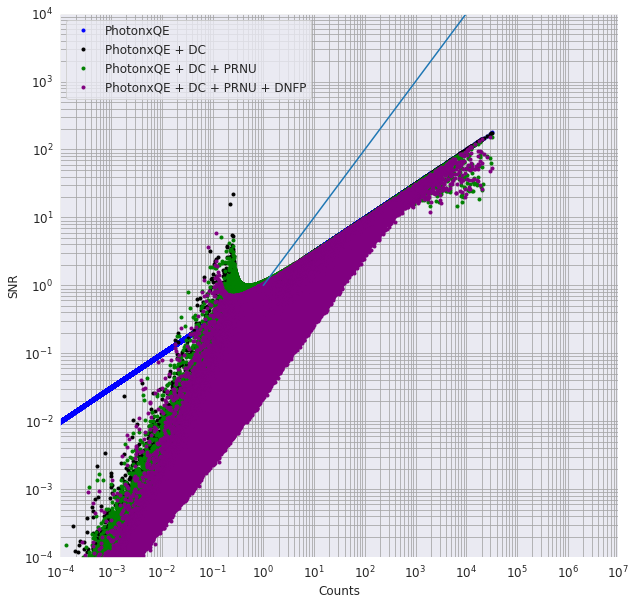

In [26]:
fig, ax = plt.subplots(1,1)

tel_params = {'sim_file': f'{data_path}/data/PSF/INSIST/on_axis_hcipy.npy',
              'pixel_scale'   : 0.1,
              'response_funcs': [f'{data_path}/data/INSIST/UV/Coating.dat,5,100',
                                 f'{data_path}/data/INSIST/UV/Dichroic.dat,1,100',
                                 f'{data_path}/data/INSIST/UV/Filter.dat,1,100',
                                 f'{data_path}/data/INSIST/UV/QE.dat,1,100']}
                                  

det_params = {'shot_noise': 'Gaussian',
                      'M_sky'      :  27,
                      'qe_sigma'   :  0.01,       # Pixel to pixel fluctuation
                      'bias'       :  35,         # electrons
                      'G1'         :  1,
                      'bit_res'    :  14,         
                      'RN'         :  5,          # elec/pix
                      'PRNU_frac'  :  0.25/100,   # PRNU sigma
                      'T'          :  218,        # K
                      'DFM'        :  1.424e-2,   # 14.24 pA
                      'pixel_area' :  1e-6,       # 
                      'DN'         :  0.1/100,    # 
                      'NF'         :  0,          # electrons 
                      'FWC'        :  1.4e5,      # electrons 
                      'C_ray_r'    :  2/50        # hits/second
                   }

exp_time = 600
n_x      = 1000
n_y      = 1000
sim =  pis.Imager(df = df, tel_params = tel_params, exp_time = exp_time, 
             n_x  = n_x, n_y = n_y)


sim.PRNU = False
sim.DNFP = False
sim.QN   = False
sim(det_params = det_params)


# Source Photoelectrons
x = (sim.source_photoelec).ravel()
y = x/np.sqrt(sim.source_photoelec).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.plot(x,y,'.', color ='blue')

sim = pis.Imager(df = df, tel_params = tel_params, exp_time = exp_time, 
             n_x  = n_x, n_y = n_y)


sim.PRNU = False
sim.DNFP = False
sim.QN   = False

det_params = {      
              'RN'         :  5,          # elec/pix
              'PRNU_frac'  :  2/100,   # PRNU sigma
              'T'          :  218,        # K
              'DN'         :  0.1/100,    # 
            }

sim(det_params = det_params)

x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.DC_array**2 ).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.plot(x,y,'.', color ='black')


# With PRNU
sim = pis.Imager(df = df, tel_params = tel_params, exp_time = exp_time, 
             n_x  = n_x, n_y = n_y)
sim.PRNU = True
sim.DNFP = False
sim.QN   = False
sim(det_params = det_params)

x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.DC_array**2+ (sim.photoelec_array*sim.PRNU_array)**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.plot(x,y,'.', color ='green')


# With PRNU and DNFP
sim = pis.Imager(df = df, tel_params = tel_params, exp_time = exp_time, 
             n_x  = n_x, n_y = n_y)
sim.PRNU = True
sim.DNFP = True
sim.QN   = False
sim(det_params = det_params)

x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.DC_array**2+ (sim.photoelec_array*sim.PRNU_array)**2 +  (sim.DC_array*sim.DNFP_array)**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.plot(x,y,'.', color ='purple')

x =  np.linspace(1,1e11)
y = x
plt.plot(x,y)


ax.set_xlabel('Counts')
ax.set_ylabel('SNR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-4,1e7)
ax.set_ylim(1e-4,1e4)
ax.xaxis.set_major_locator(LogLocator(numticks=15))
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10)))

plt.grid(True, which="both",axis = 'both', ls="-", color='0.65')
plt.legend(['PhotonxQE', 'PhotonxQE + DC','PhotonxQE + DC + PRNU','PhotonxQE + DC + PRNU + DNFP']);

Text(0.5, 0, 'Y')

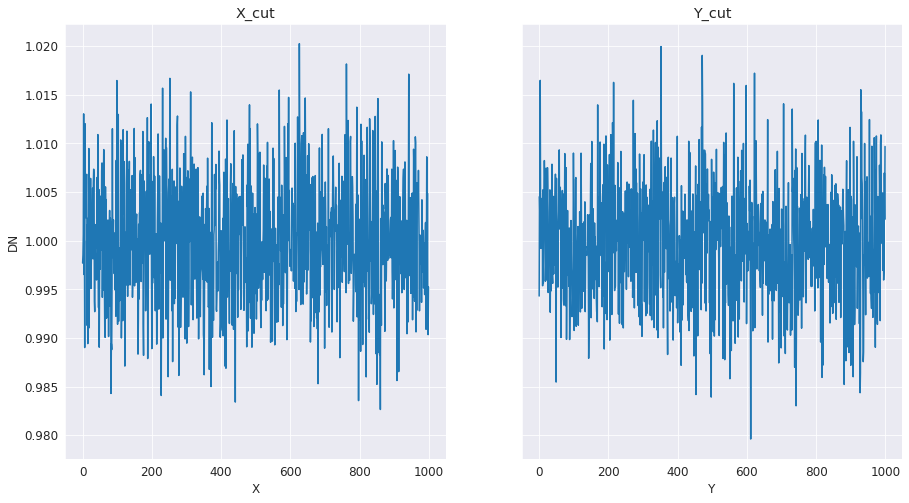

In [27]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.DNFP_array[:,500])
ax[0].set_title('X_cut')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(sim.DNFP_array[50,:])
ax[1].set_title('Y_cut')
ax[1].set_xlabel('Y')

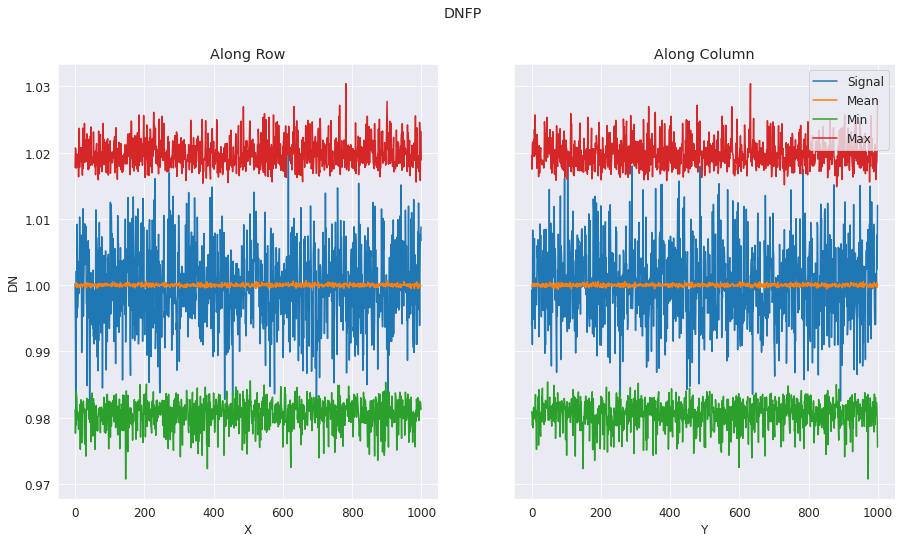

In [28]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.DNFP_array[:,392])
ax[0].plot(sim.DNFP_array.mean(axis = 0))
ax[0].plot(sim.DNFP_array.min(axis = 0))
ax[0].plot(sim.DNFP_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(sim.DNFP_array[392,:])
ax[1].plot(sim.DNFP_array.mean(axis = 1))
ax[1].plot(sim.DNFP_array.min(axis = 1))
ax[1].plot(sim.DNFP_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('DNFP')
plt.legend(['Signal', 'Mean','Min','Max'])

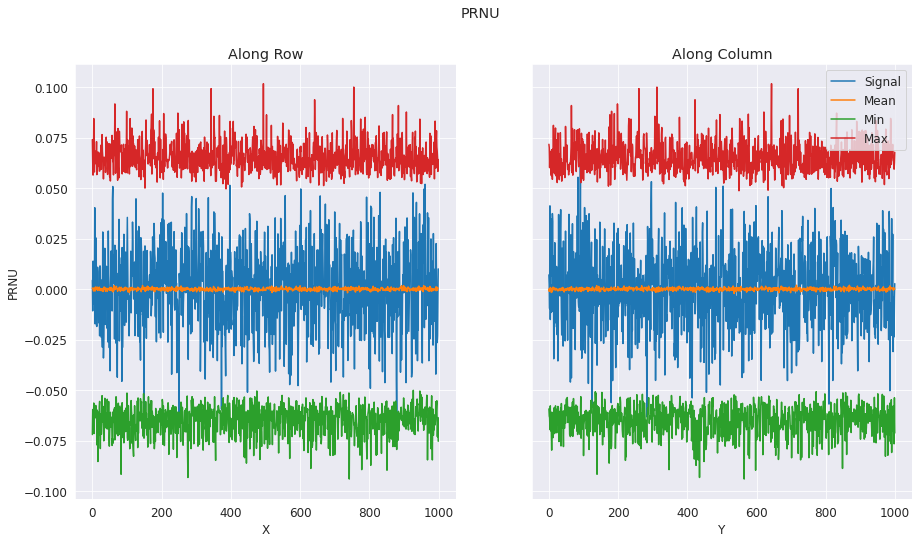

In [29]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.PRNU_array[:,392])
ax[0].plot(sim.PRNU_array.mean(axis = 0))
ax[0].plot(sim.PRNU_array.min(axis = 0))
ax[0].plot(sim.PRNU_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('PRNU')
ax[1].plot(sim.PRNU_array[392,:])
ax[1].plot(sim.PRNU_array.mean(axis = 1))
ax[1].plot(sim.PRNU_array.min(axis = 1))
ax[1].plot(sim.PRNU_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('PRNU')
plt.legend(['Signal', 'Mean','Min','Max'])

### **Off axis Vs On Axis**

In [30]:
tel_params_off ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/data/PSF/INSIST/off_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/data/INSIST/UV/Filter.dat,1,100',    
                                  f'{data_path}/data/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                 f'{data_path}/data/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                 f'{data_path}/data/INSIST/UV/QE.dat,1,100'
                                ],                                
            } 

tel_params_on ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/data/PSF/INSIST/on_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/data/INSIST/UV/Filter.dat,1,100',    
                                  f'{data_path}/data/INSIST/UV/Coating.dat,6,100',   # 5 mirrors
                                  f'{data_path}/data/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  f'{data_path}/data/INSIST/UV/QE.dat,1,100'
                                ],    
            'coeffs'          : 0.17                 
            } 

In [31]:
y,x = np.mgrid[1:10,1:10]/3600

In [32]:
ra  = 10 + x.ravel()
dec = 10 + y.ravel()
mag = np.linspace(20,30,100)
df = pd.DataFrame(zip(ra,dec,mag), columns = ['ra','dec','mag'])

In [33]:
sim_off = pis.Imager(df = df,tel_params = tel_params_off, n_x = 100, n_y = 100, 
                   exp_time = 2400)
sim_on = pis.Imager(df = df,tel_params = tel_params_on,   n_x = 100, n_y = 100, 
                   exp_time = 2400)

In [34]:
sim_off.W_eff, sim_off.lambda_phot

(1073.8346166986241, 2250.7513440953817)

In [35]:
sim_on.W_eff, sim_on.lambda_phot

(1036.9987519945291, 2269.8324306168247)

In [36]:
sim_off.zero_flux/sim_on.zero_flux

6.944542340641806

In [41]:
det_params = {    'shot_noise' :  'Gaussian',
                  'G1'         :  1,
                  'PRNU_frac'  :  0.25/100,
                  'RN'         :  5,
                  'T'          :  218,        
                  'DN'         :  0.1/100     
                     }

In [42]:
sim_off(det_params = det_params)
sim_on(det_params = det_params)

/usr/local/lib/python3.8/dist-packages/pista/analysis.py:98: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out']  = -2.5*np.log10(phot_table['flux']/zero_p_flux)
/usr/local/lib/python3.8/dist-packages/pista/analysis.py:98: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out']  = -2.5*np.log10(phot_table['flux']/zero_p_flux)


(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7f792f04b0d0>)

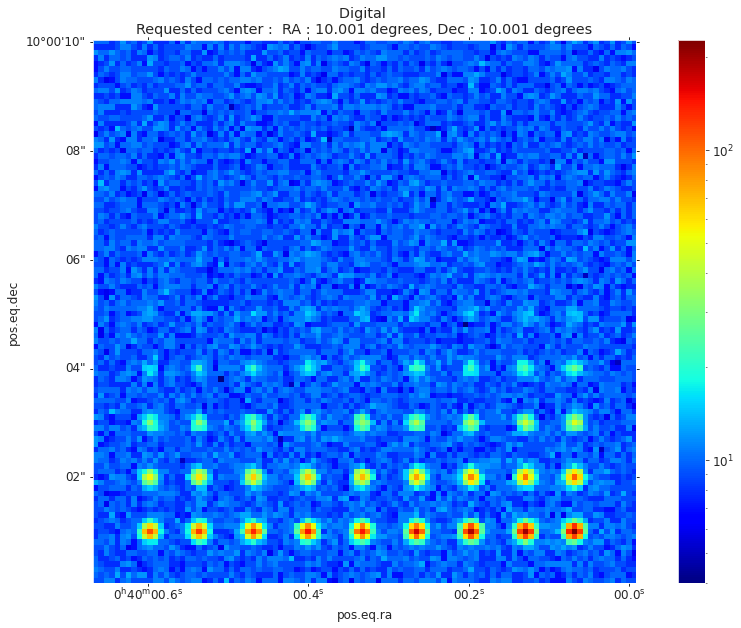

In [43]:
sim_on.show_image()

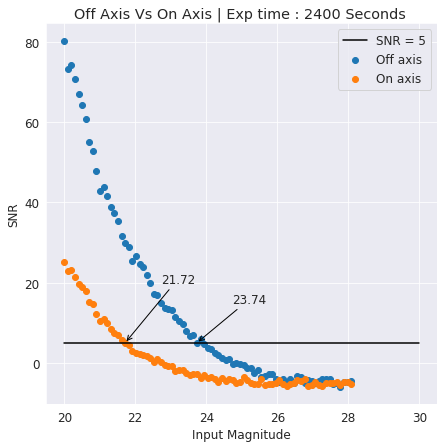

In [44]:
fig, ax = plt.subplots(1,1, figsize = (7,7))

data = sim_off.phot_table
x = data['mag_in']
y = data['SNR']

t = np.where(y<5)[0][0]
ax.scatter(x,y )

ax.plot([20,30],[5,5], color = 'black')
ax.set_title('Off Axis Vs On Axis | Exp time : 2400 Seconds ')

ax.annotate('{0:.2f}'.format(x[t]), (x[t],5), xytext = (x[t]+1,5+10),arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color = 'black'))

data = sim_on.phot_table
x = data['mag_in']
y = data['SNR']

t = np.where(y<5)[0][0]
ax.scatter(x,y )
ax.set_xlabel('Input Magnitude')
ax.set_ylabel('SNR')
ax.legend(['SNR = 5', 'Off axis', 'On axis'])
ax.annotate('{0:.2f}'.format(x[t]), (x[t],5), xytext = (x[t]+1,5+15),arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color = 'black'))

plt.subplots_adjust(wspace = 0.01)

# **ArtPop**
Work in progress

In [ ]:
!pip install artpop --quiet

In [47]:
import artpop as art

/root/.artpop/mist. To change this location, create a MIST_PATH environment variable.


In [ ]:
art.phot_system_list

In [51]:
rng = np.random.RandomState(369)

In [69]:
src = art.MISTSersicSSP(
    log_age = 6,        # log of age in years
    feh = -2.5,           # metallicity [Fe/H]
    r_eff = 250 * u.pc,   # effective radius
    n = 0.8,              # Sersic index
    theta = 135 * u.deg,  # position angle
    ellip = 0.3,          # ellipticity
    num_stars = 1e6,      # number of stars
    phot_system = 'GALEX', # photometric system
    distance = 5 * u.Mpc, # distance to system
    xy_dim = 801,         # image dimension
    pixel_scale = 0.1,    # pixel scale in arcsec / pixel
    random_state = rng,   # random state for reproducibility
)

In [70]:
imager = art.ArtImager(
    phot_system  = 'GALEX', # photometric system
    diameter     =  1*u.m, # effective aperture diameter
    read_noise   = 3,       # read noise in electrons
    random_state = rng    # random state for reproducibility
)

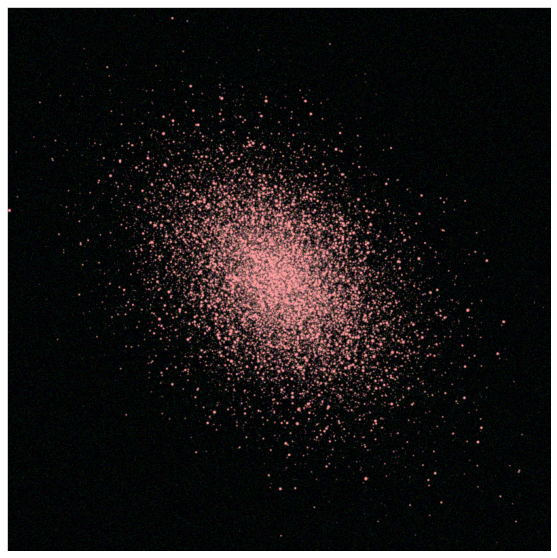

In [71]:
psf = art.moffat_psf(fwhm=0.2*u.arcsec)

# observe in gri (assuming the same seeing in all bands)
obs_g = imager.observe(
    source = src,         # source object
    bandpass = 'GALEX_NUV',  # bandpass of observation
    exptime = 10 * u.min, # exposure time
    sky_sb = 27,          # sky surface brightness
    psf = psf             # point spread function
)
obs_r = imager.observe(src, 'GALEX_NUV', 10 * u.min, sky_sb=27, psf=psf)
obs_i = imager.observe(src, 'GALEX_FUV', 30 * u.min, sky_sb=27, psf=psf)

rgb = make_lupton_rgb(obs_i.image, obs_r.image, obs_g.image, stretch=0.4)

art.show_image(rgb);

In [73]:
from astropy.wcs import WCS

In [120]:
w = WCS(naxis=2)
w.wcs.crpix = [801//2, 801//2]
w.wcs.cdelt = np.array([-0.1/3600,0.1/3600])
w.wcs.crval = [10,10]
w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
wcs = w

In [121]:
pos = np.array([src.x, src.y])

In [122]:
coords = wcs.pixel_to_world_values(pos.T)

In [123]:
df = pd.DataFrame(coords, columns =['ra', 'dec'])

In [124]:
df['mag'] = src.mags['GALEX_NUV']

In [125]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/data/PSF/INSIST/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_path}/data/INSIST/UV/Filter.dat,1,100',    
                                  f'{data_path}/data/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                  f'{data_path}/data/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  f'{data_path}/data/INSIST/UV/QE.dat,1,100'
                                ],                                
            } 

In [126]:
df = df[df['mag']<30]

In [128]:
sim = pis.Imager(df = df,tel_params = tel_params, n_x = 801, n_y = 801, 
                   exp_time = 1800)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7937a93190>)

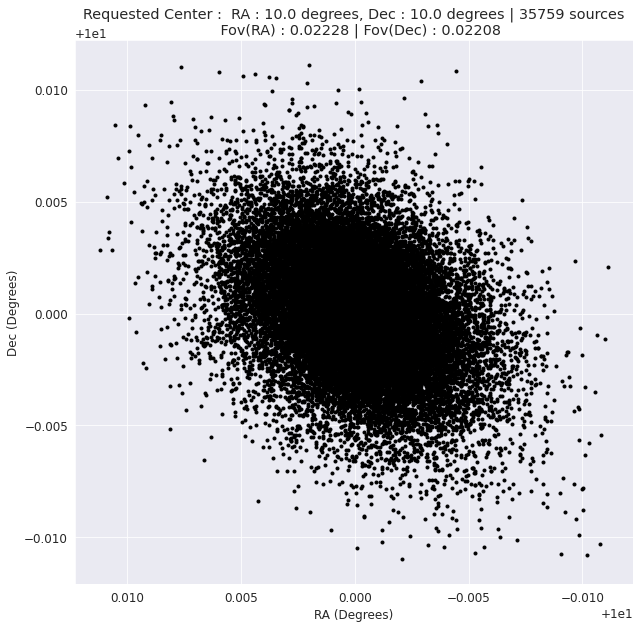

In [129]:
sim.show_field()

In [130]:
det_params = {    'shot_noise' :  'Gaussian',
                  'G1'         :  1,
                  'PRNU_frac'  :  0.25/100,
                  'RN'         :  5,
                  'T'          :  218,        
                  'DN'         :  0.1/100     
                     }

In [ ]:
sim(det_params = det_params, photometry = 'Aper', detect_source = False)

In [ ]:
sim.show_image(cmap = 'gray') # Displays the final simulated digital image

# **GalSim**

Work in progress

In [ ]:
import galsim 

In [ ]:
# Bulge
gal_flux    = 406581      # total counts on the image
rhalf       = 1.62*0.394 # arcsec
sim_sigma   = 0.2         # arcsec
 
q=0.88
g = (1-q)/(1+q)
g = abs(g)
beta = -24*np.pi/180
g1 = g*np.cos(2*beta)
g2 = g*np.sin(2*beta)

gal     = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal     = gal.shear(g1 = g1, g2 = g2)
rot_gal = gal.rotate(beta* galsim.radians)
sim     = galsim.Gaussian(flux=1., sigma=sim_sigma) # sim flux should always = 1
bulge   = galsim.Convolve([gal, sim])

#Bar
gal_flux    = 341309      # total counts on the image
rhalf       = 5.76*0.394 # arcsec

q = 0.42
g = (1-q)/(1+q)
beta = -72*np.pi/180
g1 = g*np.cos(2*beta)
g2 = g*np.sin(2*beta)

gal     = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal     = gal.shear(g1 = g1, g2 = g2)
rot_gal = gal.rotate(beta* galsim.radians)
sim     = galsim.Gaussian(flux=1., sigma=sim_sigma) # sim flux should always = 1
bar     = galsim.Convolve([gal, sim])

#Disk
gal_flux    = 1639787     # total counts on the image
rhalf       = 9.1312*0.394  # arcsec
sim_sigma   = 0.2         # arcsec

q = 0.8591
g = (1-q)/(1+q)
beta = 3.2633*np.pi/180
g1 = g*np.cos(2*beta)
g2 = g*np.sin(2*beta)

gal     = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal     = gal.shear(g1 = g1, g2 = g2)
rot_gal = gal.rotate(beta* galsim.radians)
sim     = galsim.Gaussian(flux=1., sigma=sim_sigma) # sim flux should always = 1
disk     = galsim.Convolve([gal, sim])

pixel_scale = 0.394         # arcsec / pixel
noise       = 4.5         # standard 

final = galsim.Add(bulge,bar,disk)
final = final.drawImage(scale=pixel_scale)
final.addNoise(galsim.GaussianNoise(sigma=noise))

In [ ]:
fig,ax= plt.subplots(2,2,figsize=(30,30))
kw={'scale':pixel_scale}
ax[0,0].imshow(bulge.drawImage(**kw).array, cmap='jet')
ax[0,0].grid(False)
ax[0,1].imshow(bar.drawImage(**kw).array, cmap='jet')
ax[0,1].grid(False)
ax[1,0].imshow(disk.drawImage(**kw).array, cmap='jet')
ax[1,0].grid(False)
ax[1,1].imshow(final.array +1000, cmap='jet')
ax[1,1].grid(False)
